## Computational ressources

In [32]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 

cluster.scale(204) 

from dask.distributed import Client
client = Client(cluster)

client

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://172.30.100.4:36587 Dashboard: http://172.30.100.4:36621/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [33]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7488612      allc make_pro albert7a PD       0:00      1 (Priority)
           7488613      allc make_pro albert7a PD       0:00      1 (Priority)
           7488614      allc make_pro albert7a PD       0:00      1 (Priority)
           7488615      allc make_pro albert7a PD       0:00      1 (Priority)
           7488616      allc make_pro albert7a PD       0:00      1 (Priority)
           7488617      allc make_pro albert7a PD       0:00      1 (Priority)
           7488618      allc make_pro albert7a PD       0:00      1 (Priority)
           7488619      allc make_pro albert7a PD       0:00      1 (Priority)
           7487968       all nemo_occ albert7a PD       0:00     49 (Resources)


In [34]:
import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(str(nb_workers)+' are ready !')

77 are ready !


In [36]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7487968       all nemo_occ albert7a PD       0:00     49 (Resources)
           7488612      allc make_pro albert7a  R       0:48      1 n2529
           7488613      allc make_pro albert7a  R       0:48      1 n2563
           7488614      allc make_pro albert7a  R       0:48      1 n3087
           7488615      allc make_pro albert7a  R       0:48      1 n2800
           7488616      allc make_pro albert7a  R       0:48      1 n2801
           7488617      allc make_pro albert7a  R       0:48      1 n2803
           7488618      allc make_pro albert7a  R       0:48      1 n2810
           7488619      allc make_pro albert7a  R       0:48      1 n2811


## Librairies and customization

In [37]:
import xarray as xr 
import dask 
import numpy as np 
import os 
import time 
import glob
from datetime import date
today=date.today()

import sys
sys.path.insert(0,'/home/albert7a/git/xscale')
import xscale

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

import matplotlib.pyplot as plt
params = {'figure.figsize' : (15, 8),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)


In [38]:
%time ds=xr.open_zarr('/store/albert7a/eNATL60/zarr/eNATL60-BLBT02-SSH-1h')
ds

CPU times: user 142 ms, sys: 39.7 ms, total: 182 ms
Wall time: 771 ms


<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 11688, x: 8354, y: 4729)
Coordinates:
    time_centered         (time_counter) datetime64[ns] dask.array<shape=(11688,), chunksize=(240,)>
  * time_counter          (time_counter) datetime64[ns] 2010-01-19T00:30:00 ... 2009-09-17T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    nav_lat               (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(240, 480)>
    nav_lon               (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(240, 480)>
    sossheig              (time_counter, y, x) float32 dask.array<shape=(11688, 4729, 8354), chunksize=(240, 240, 480)>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(240, 2)>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<shape=(11688, 2), chunksize=(240, 2)>
Attributes:
    Conventions:  CF-1.6
    TimeStamp:    24/03/2019 14:43:2

In [39]:
ds_sorted=ds.sortby('time_counter')

In [40]:
print(ds.nbytes/1e9)

1847.304207184


In [41]:
ssh_FMA=ds_sorted.sel(time_counter=slice('2010-02-01','2010-04-30'))['sossheig']

In [72]:
ssh_ASO=ds_sorted.sel(time_counter=slice('2009-08-01','2009-10-31'))['sossheig']

In [42]:
ssh_FMA

<xarray.DataArray 'sossheig' (time_counter: 2136, y: 4729, x: 8354)>
dask.array<shape=(2136, 4729, 8354), dtype=float32, chunksize=(24, 240, 480)>
Coordinates:
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(2136,), chunksize=(24,)>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010-04-30T23:30:00
Dimensions without coordinates: y, x
Attributes:
    interval_write:    1 h
    long_name:         sea surface height
    online_operation:  average
    standard_name:     sea_surface_height_above_geoid
    units:             m

In [43]:
time=ssh_FMA['time_counter']

In [65]:
with np.printoptions(threshold=np.inf):
    print(time[::12].values)

['2010-02-01T00:30:00.000000000' '2010-02-01T12:30:00.000000000'
 '2010-02-02T00:30:00.000000000' '2010-02-02T12:30:00.000000000'
 '2010-02-03T00:30:00.000000000' '2010-02-03T12:30:00.000000000'
 '2010-02-04T00:30:00.000000000' '2010-02-04T12:30:00.000000000'
 '2010-02-05T00:30:00.000000000' '2010-02-05T12:30:00.000000000'
 '2010-02-06T00:30:00.000000000' '2010-02-06T12:30:00.000000000'
 '2010-02-07T00:30:00.000000000' '2010-02-07T12:30:00.000000000'
 '2010-02-08T00:30:00.000000000' '2010-02-08T12:30:00.000000000'
 '2010-02-09T00:30:00.000000000' '2010-02-09T12:30:00.000000000'
 '2010-02-10T00:30:00.000000000' '2010-02-10T12:30:00.000000000'
 '2010-02-11T00:30:00.000000000' '2010-02-11T12:30:00.000000000'
 '2010-02-12T00:30:00.000000000' '2010-02-12T12:30:00.000000000'
 '2010-02-13T00:30:00.000000000' '2010-02-13T12:30:00.000000000'
 '2010-02-14T00:30:00.000000000' '2010-02-14T12:30:00.000000000'
 '2010-02-15T00:30:00.000000000' '2010-02-15T12:30:00.000000000'
 '2010-02-16T00:30:00.000

In [66]:
ssh_FMA_reg=ssh_FMA[:,1950:2050,3850:4150]

In [73]:
ssh_ASO_reg=ssh_ASO[:,1950:2050,3850:4150]

In [67]:
NPADDING = 2
%time SPtime_FMA_reg = xfft.fft(ssh_FMA_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_FMA_reg.shape[0]*NPADDING,tapering=True)


CPU times: user 3.47 s, sys: 1.37 s, total: 4.84 s
Wall time: 6.42 s


In [74]:
SPtime_ASO_reg = xfft.fft(ssh_ASO_reg, dim='time_counter', dx=1., detrend='mean',nfft=ssh_ASO_reg.shape[0]*NPADDING,tapering=True)


In [68]:
SPtime_FMA_reg

<xarray.DataArray 'spectrum' (f_time_counter: 2137, y: 100, x: 300)>
dask.array<shape=(2137, 100, 300), dtype=complex128, chunksize=(2136, 100, 300)>
Coordinates:
  * y               (y) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * x               (x) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * f_time_counter  (f_time_counter) float64 0.0 0.0002341 ... 0.4998 0.5
Attributes:
    ps_factor:   1.0958913717403807e-07
    psd_factor:  0.00046816479400749064

In [69]:
%time MEANPSD_FMA=xfft.psd(SPtime_FMA_reg).mean(dim='x').mean(dim='y').load()


CPU times: user 2.33 s, sys: 1.19 s, total: 3.51 s
Wall time: 17.9 s


In [75]:
MEANPSD_ASO=xfft.psd(SPtime_ASO_reg).mean(dim='x').mean(dim='y').load()


In [70]:
freqs_FMA=MEANPSD_FMA.f_time_counter.values
freqs_FMA = freqs_FMA[NPADDING::] 


In [76]:
freqs_ASO=MEANPSD_ASO.f_time_counter.values
freqs_ASO = freqs_ASO[NPADDING::] 


Text(0.5, 1.0, 'Temporal Spectrum of SSH in the box')

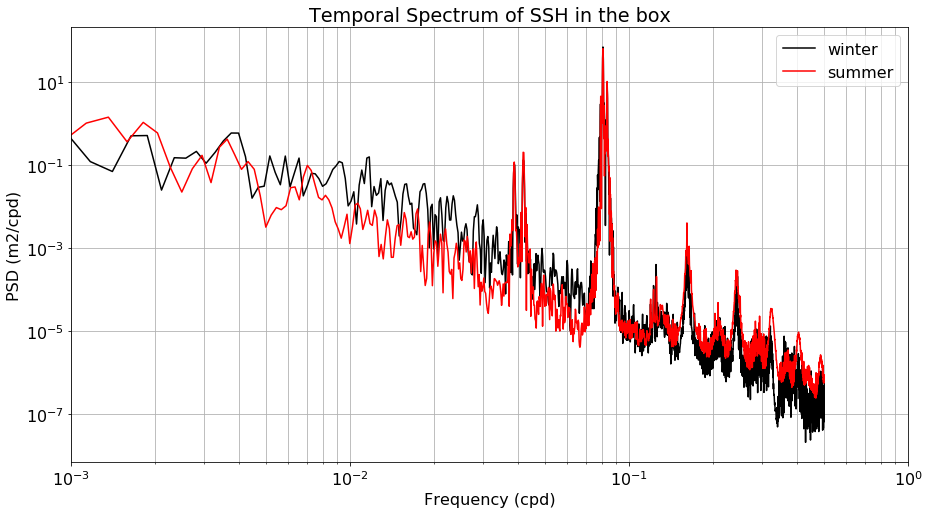

In [77]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_FMA,MEANPSD_FMA[NPADDING::],'k',label='winter')
ax.loglog(freqs_ASO,MEANPSD_ASO[NPADDING::],'r',label='summer')
ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cpd)')
plt.ylabel('PSD (m2/cpd)')
plt.legend()
plt.title('Temporal Spectrum of SSH in the box')